# Data Science Project 

# Introduction:

This project explores the relationship between demographic variables and COVID-19 death rates during the first week of January 2021. This week saw the peak in cases since the start of the pandemic and led to the third national lockdown on the 5th of January (Prime Minister’s Office, 2021). The rapid rise in cases was driven by the new COVID mutation that is said to be 70% more infectious and has quickly spread accross the UK (Kirby, 2021). A report published by Public Health England (2020) found that in previous waves certain groups were more vulnerable to the virus. For example, they found higher death rates for Black, Asian and Minority Ethnic (BAME) groups than for White ethnic groups. Among those diagnosed with COVID- 19, people who were 80 or older were seventy times more likely to die than those under 40. The report also showed that deprived areas in the UK also have higher COVID death rates. I want to explore how density, proportion of over 60s and non-white population as well as median pay are related to death rate in England during this first week of the year. I also want to compare death rates between regions, and how these have been distributed geographically.

My analysis is split up into three sections. The first involves curating the dataset I will be using and performing simple exploratory analysis. The next section implements the K-means clustering algorithm to group together observations that share similar demographic characteristics. This will help me spot any trends in death rate and number of cases for each of the clusters. Finally, I will use supervised machine learning algorithms such as linear and random forest regression to create a predictive model for death rate. 

# Section 1: The Data

The first step in our analysis is to gather the data we will need. The data has been extracted from various sources including the 2011 England Census, the Annual Survey of Hours and Earnings (ASHE), and ONS weekly COVID-19 cases and deaths. I calculated the death rate using population estimates from the 2019 mid-year population estimate. The COVID data is from the first week of January 2021. All of these sources can be downloaded from the [ONS website](https://www.ons.gov.uk).

In [1]:
import numpy as np
import pandas as pd

# first step is to import the data that we'll be using to build the final dataset
dfdemo = pd.read_excel('censusdata.xlsx') # 2011 Census data
dfcovid = pd.read_excel('covidons2.xlsx') # ONS COVID-19 data
weeklypay = pd.read_excel('weeklypay.xlsx') # ASHE data
deaths = pd.read_excel('deaths.xlsx') # ONS data on number of deaths registered/occurences on the 1st week of january 2021
pop = pd.read_excel('pop.xlsx') # ONS data: population for each LA. We need this to compute the death rate per 100k

In [2]:
weeklypay.Description = [c.strip() for c in weeklypay.Description] #get rid of whitespaces
weeklypay.columns = ['Local_Authority', 'Median_Pay'] # rename columns
weeklypay['Median_Pay'].replace('x', np.nan, inplace=True) # replace missing data with NaN
weeklypay = weeklypay.dropna() # drop all rows that have missing values
weeklypay['Median_Pay'].astype(float) # recast string into float type

# drop NaN, subset data and rename it.
dfcovid = dfcovid.dropna() # drop all rows that have missing values
dfcovid = dfcovid[['Lower Tier Local Authority','Region','Case rate per 100,000 population (weekly)', 'Trend.1', 'Case rate per 100,000 population aged 60 years and over (weekly)','Trend.2']]
dfcovid.columns = ['Local_Authority','Region','Cases_per100k', 'Trend1', 'Cases_per100k_over_60', 'Trend2']

# death rate
deaths1 = deaths[deaths.Week.isin(['Week 01']) & \
       deaths.CauseOfDeath.isin(['COVID 19']) & \
       deaths.RegistrationOrOccurrence.isin(['Occurrences'])                        
      ][['Geography', '2021']] # we look for the number of death occurences in Week 1 from COVID
aggregation_functions = {'Geography': 'first', '2021': 'sum'} # functions we want to apply to selection
death_new = deaths1.groupby(deaths1['Geography']).aggregate(aggregation_functions)
death_final = death_new
death_final.columns = ['Local_Authority','Deaths'] # rename columns
death_final = death_final.reset_index(drop = True)
pop.columns = ['Local_Authority', 'Population'] # rename columns
death_rates = pd.merge(pop, death_final, on = 'Local_Authority') # merge two datasets to match LAs and get matrix same size
death_rates['Death_Rate'] =death_rates['Deaths'] * 100000 / death_rates['Population'] # compute death rate and include as column

# subset data, rename it (no NaN values)
my_vars = ['Local Authority','Density (number of persons per hectare)', '% Over 60', '% white', '% mixed', '% asian', '% black', '% other', '% total (non white ethnicity)']
dfdemo = dfdemo[my_vars]
dfdemo.columns = ['Local_Authority', 'Density', 'Over_60', 'White', 'Mixed', 'Asian', 'Black', 'Other', 'Non_white']
dfdemo = dfdemo.dropna()

# merge the datasets on Local Authority column
df_original = pd.merge(dfdemo, weeklypay, on = 'Local_Authority')
df_original = pd.merge(df_original, death_rates, on = 'Local_Authority')
df_original = pd.merge(df_original, dfcovid, on = 'Local_Authority')

sel_vars = ['Local_Authority', 'Density', 'Over_60', 'Non_white', 'Median_Pay', 'Region', 'Cases_per100k','Death_Rate']
df = df_original[sel_vars]

From our cleaned and merged dataset we selected a subset of the variables we are interested in for our analysis. Each row represents data for a local authority (LA). We have the following observables: population density (measured as persons per hectare), percentage of population of over 60s, percentage of non-white population, region in England, number COVID-19 cases per 100k in the local population, and death rate (deaths per 100k) in the local population.

We are now ready to explore our dataset. We are most interested in COVID cases and death rates. The following histogram compares the mean number of cases and death rates according to region.

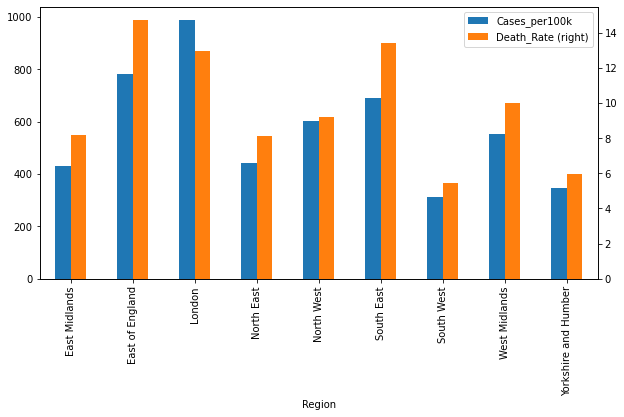

In [3]:
df.groupby(['Region'])[['Cases_per100k', 'Death_Rate']].mean().plot(kind = 'bar',\
                                                                    sharex = True,\
                                                                    figsize = (10,5),\
                                                                    secondary_y='Death_Rate');                                                             

London has the highest average number of COVID-19 cases, nearly 1000 per 100k of the population. It also has a high death rate, but not as high as in the East of England, despite having less cases than London. The next highest death rate is in the South East of England. This information is not surprising. We know that the first case of the new COVID variant originated from the south eastern region of the country (WHO, 2020). This is reflected in the high number of cases for London and the surrounding area. The region with the lowest number of cases and death rates is the South West, followed by Yorkshire and Humber.

It is interesting to note that despite having the highest number of cases, the London region does not have the highest death rate.

# Section 2: Unsupervised Learning

In this section I will use unsupervised machine learning algorithms such as K-means clustering. I will group LAs that are similar according to the demographic variables I have chosen to include for this analysis. We will then check whether the clusters also show some patterns in the number of cases and death rates.

Before we can apply the algorithm to our data, we need to standardise it for the following reasons:

* Our variables are measured on different scales. The clustering algorithm relies on measuring Euclidean distance between the different observations we are trying to cluster. Therefore, since the scales of our variables are different, higher scales will over-influence whatever we are trying to measure. So in order to apply K-means we have to standardise to make sure all of our variables are contributing equally.

* We will be using Principal Component Analaysis (PCA) to create an alternative K-means clustering model. PCA gives more weight to variables that have a higher variances. Again, since the scales of our variables are different, we cannot use the raw data for PCA. It is necessary to standardise the raw values. Standardizing makes equal variance so high weight is not assigned to variables having higher variances.


In [4]:
df_std = df[['Density','Over_60', 'Non_white', 'Median_Pay', 'Cases_per100k', 'Death_Rate']] # select cts vars
df_std = (df_std-df_std.mean())/df_std.std() # standardising
df_std['Region'] = df['Region'] # adding the categorical data back in

We import the necessary modules we'll need for this section.

In [5]:
from numpy.random import seed
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn import metrics
import seaborn as sns

We then choose a subsection of the variables we're interested for the clustering. In this case, we're choosing the demographic data.

In [6]:
cluster_vars = ['Density','Over_60', 'Non_white', 'Median_Pay']
df_clus = df_std[cluster_vars]

Since we do not yet know how many clusters to split our data into, we will run a silhouette test to find the optimal k. This is a widely used technique for cluster validation (Thinsungnoen et al., 2015).

In [7]:
seed(12345)
sil = {}
for i in [3, 4, 5, 6 ,7, 8 ]:
    estimatortest = KMeans(n_clusters=i) # creating object with model
    estimatortest.fit(df_clus) # fitting the data
    sils = metrics.silhouette_score(df_clus, 
                                    estimatortest.labels_, 
                                    metric='euclidean')
    sil[i] = sils
sil = pd.Series(sil) # making the data into a pd dataframe
# sil.plot.line(); # creating the plot
print('Optimal k = {}'.format(sil.idxmax())) # gives us the index of the max silhouette score

Optimal k = 5


Our analysis indicates the optimal k = 5. We are now ready to run the algorithm on our standardised data.

In [8]:
k = 5
estimator = KMeans(n_clusters = k)
seed(12345)
estimator.fit(df_clus)
cluster_raw = pd.Series(estimator.labels_,
                       index = df.index
                       )

For our second clustering model, we will first apply PCA with 2 components to the data. The new, lower-dimension data will be useful to compare both clustering models as it allows us to plot the results.

In [9]:
pca_estimator = PCA(n_components = 2)
lower_d_data = pca_estimator.fit_transform(df_clus) 
lower_d_data = pd.DataFrame(lower_d_data,
                           index = df_clus.index,
                           columns = ["C-1", "C-2"]
                           )

In [10]:
seed(12345)
estimator1 = KMeans(k) # start the model
estimator1.fit(lower_d_data) # fit data to model
k_pca = pd.Series(estimator1.labels_,
                  index = lower_d_data.index) # convert model labels to a dataframe

Once we have our two models, we are ready to visualise the results. We can do this by plotting the results using the PCA components and visually comparing how the algorithm has performed the clustering in both models.

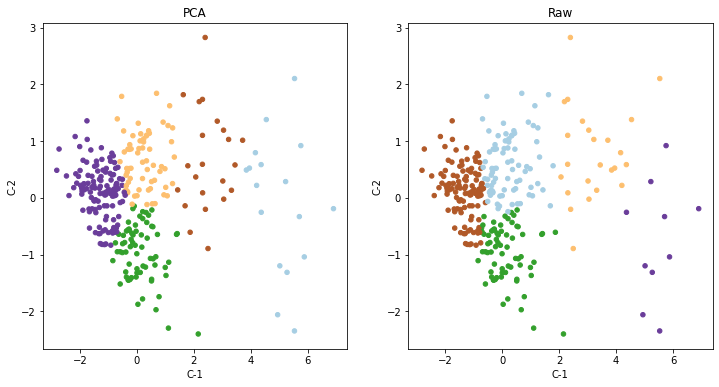

In [11]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0] # 1st subplot
lower_d_data.assign(labels=k_pca)\
          .plot.scatter("C-1", 
                        "C-2",
                        c="labels",
                        #s=1,
                        cmap="Paired",
                        colorbar=False,
                        ax=ax
                       )
ax.set_title("PCA")

ax = axs[1] # 2nd subplot
lower_d_data.assign(labels=cluster_raw)\
          .plot.scatter("C-1", 
                        "C-2",
                        c="labels",
                        #s=1,
                        cmap="Paired",
                        colorbar=False,
                        ax=ax
                       )
ax.set_title("Raw")

plt.show()

These two clustering results are fairly similar. 

To compare how good the clustering is in each of these models, we will calculate the Calinski-Harabasz score for both. This statistic will give us an indication of how good the clustering is in each model. It is a technique commonly used to test clustering performance (Raykov et al., 2016).

In [12]:
chs = {'Raw K-means' : calinski_harabasz_score(df_clus, 
                              estimator.labels_),
       'PCA K-means': calinski_harabasz_score(df_clus, 
                              estimator1.labels_)}
chs

{'Raw K-means': 247.85739754209507, 'PCA K-means': 228.52103060705178}

A higher Calinski-Harabasz score indicates better clustering. Since the value for the raw K-means model is the highest (247.9), we can conclude that this is the prefered clustering method for this analysis.

We are now ready to explore the distribution of the data within each cluster. To do this, we first create a new data frame that will reorganise our data and will include the cluster ID for each of the observations. We are then going to use the FacetGrid module from the Seaborn library to explore the distributions of each variable within each grouping. 

In [13]:
hm_vars = ['Density','Over_60', 'Non_white', 'Median_Pay', 'Cases_per100k','Death_Rate'] 
tidy_df = df[hm_vars]\
            .stack()\
            .reset_index()\
            .rename(columns={"level_1": "Var",
                             "level_0": "ID",
                             0: "Value",
                             #1: "Cases"
                            })\
            .join(pd.DataFrame({"Label": cluster_raw}),
                  on="ID")
#tidy_df

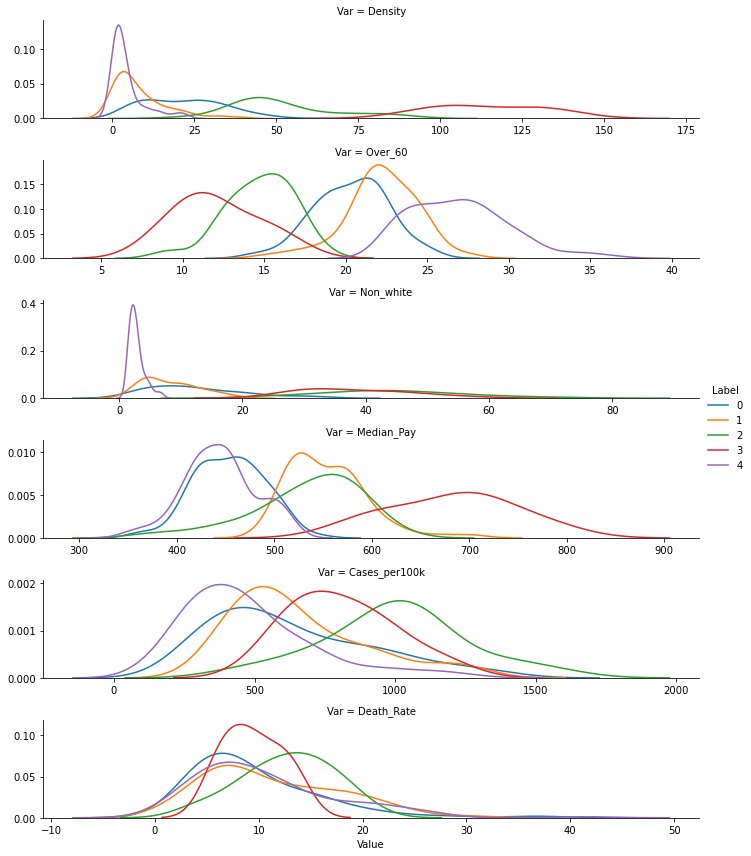

In [14]:
# plot kde distribution of each var
g = sns.FacetGrid(tidy_df,
                  row="Var",
                  hue="Label",
                  height=2,
                  aspect=5,
                  sharey = False,
                  sharex = False
                 )
g.map(sns.kdeplot, 
      "Value", 
     )
g.add_legend();

Immediately we can see that the Density and Non_white distributions are very similar. There is a lot of variation within each of these clusters, apart from cluster group 4. We also note that cluster 0, 1 and 4 have the highest proportions of over 60s, and are amongst those with lowest median pay. They have the lowest number of COVID cases and similar distributions of death rates. 

The plots also reveal that the two groups with the lowest proportion of over 60s also have the highest number of COVID cases. They are also amongst those with highest median salary. These two clusters mainly represent London, as can be verified in the following.

In [15]:
london = df['Region'] == 'London'
cluster23 =(cluster_raw == 2) | (cluster_raw == 3)
print( 'There are {} LAs in London out of a total of {}.'\
      .format( df[london & cluster23].shape[0] , cluster23.value_counts()[1]))

There are 27 LAs in London out of a total of 34.


There are 27 out of 34 LAs belonging to the London region. That is, clusters 2 and 3 heavily represent London. The analysis shows that within London there are two different trends occuring, albeit quite similar.

On the other hand, the death rate of the rest of the clusters follow a very similar distribution to each other. So from this analysis, it appears that the death rate of most areas outside of London follow a similar trend.

From the clustering we can infer that the death rates follow a similar distribution in the whole of England, apart from London. Instead, in this region there is a higher death rate and number of cases, and there are two different patterns that show up in the analysis.

# Section 3: Supervised Learning

In this section we will create a predictive model for the COVID death rate in a given area, accounting for region. We will explore how demographic variables such as median pay, over 60s and not-white population affect the death rate. I will be using linear regression and random forest models for comparison.

Before we can begin, let's state the assumptions we are making for the linear regression.
* Linear relationship: We assume our predictor variables have a linear relationship with the response variable.
* Multivariate normality: Assume that the variables are normally distributed and that any linear combination of the variables is also normally distributed.
* Homoscedasticity : The variance of the residual, or error term, in a regression model is constant.
* No or little multicollinearity: Assumes our explanatory variables are not highly linearly related.

To test multicollinearity, we are going to calculate the Variance Inflation Factor. This statistic gives us a measure of collinearity and allows us to delete the variables that are most correlated and can affect our regression analysis.

In [16]:
dfr = pd.get_dummies(data=df_std[[ 'Over_60', 
                                  'Non_white',
                                  'Median_Pay',
                                  #'Density' ,
                                  'Region' ,
                                  #'Cases_per100k',
                                 'Death_Rate']])
X = dfr.drop('Death_Rate', 1) # defining our X vars
Y = dfr['Death_Rate'] # defining our Y var

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data.max())

feature    Region_Yorkshire and Humber
VIF                            4.17599
dtype: object


James et al's (2013) suggest a VIF lower than 5 is adequate to run a multivariate analysis. Our maximum VIF value is still than 5, so using James et al's guideline we can conclude that our selected variables are adequate for the analsyis.

Now that I have prepped my data and selected the predictor variables I want to use for my model, I am ready to run the regression analysis.

In [18]:
from statsmodels.api import OLS
OLS(Y,X).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Over_60,0.2727,0.085,3.196,0.002,0.105,0.441
Non_white,0.0893,0.100,0.889,0.375,-0.108,0.287
Median_Pay,-0.1295,0.071,-1.831,0.068,-0.269,0.010
Region_East Midlands,-0.4659,0.140,-3.338,0.001,-0.741,-0.191
Region_East of England,0.6643,0.130,5.115,0.000,0.409,0.920
Region_London,0.8269,0.249,3.326,0.001,0.338,1.316
Region_North East,-0.4599,0.258,-1.780,0.076,-0.968,0.049
Region_North West,-0.2954,0.142,-2.076,0.039,-0.575,-0.015
Region_South East,0.4738,0.112,4.236,0.000,0.254,0.694
Region_South West,-1.0379,0.179,-5.786,0.000,-1.391,-0.685


Since we have standardised the data, it is easy to interpret the regression coeffiecients. The region of the LA has the strongest impact on death rate. For example, being in London increases the death rate by 0.8269 standard deviations. The East and South East of England bring up the death rate by 0.6643 and 0.4738 standard deviations respectively.

There are regions which have a negative relationship to death rate. Being situated in the South West region is associated with a decrease in death rate by 1.0379 standard deviations. In the Yorkshire and Humber region, death rate decreases by 0.8640 standard deviations. The North West and East Midlands have associated coefficients of -0.2954 and -0.4659. The North East and West Midlands are not statistically significant (p > 0.05). 

In general, we can spot a regional trend, where London and South Eastern regions have an associated higher death rate than in the rest of the country. This is similar to the findings from the cluster analysis.

What about the effect of the other variables, accounting for region? An increase of 1 standard deviation in over 60s population increases the death rate by 0.2727. It turns out to be the only statstically significant demographic variable in our analysis. Median pay and percentage of non-white population are not statistically significant (p > 0.05). 

Next, we use linear regression as a predictive model and will test its accuracy. To do this we will perform an out-of-sample test to see how well our model works with an independent dataset.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from numpy import exp, log1p, sqrt

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.8
                                                   )
lm_estimator = LinearRegression()
# Fit on X/Y train
lm_estimator.fit(x_train, y_train)
# Predict on X test
lm_y_pred = lm_estimator.predict(x_test)
# Evaluate on Y test
sqrt(mse(y_test, lm_y_pred))

0.9501274185293642

The mean squared error (MSE) of our linear regression model is approximately 0.95. We will now perform the same test on a model based on random forest regression.

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_estimator = RandomForestRegressor(n_estimators=100,
                                     max_features=None
                                    )
# Train on X/Y train
rf_estimator.fit(x_train, y_train)
# Predict on X test
rf_y_pred = rf_estimator.predict(x_test)
# Evaluate on Y test
sqrt(mse(y_test, rf_y_pred))

1.0220049427805566

The MSE of the random forest model (1.02) which is higher than for our linear model (0.95). This means our original linear regression model performs better.

# Limitations and further improvements

The dataset used in this project is only a snapshot of the national pademic situation. Therefore the predictive model from Section 3 is not relevant for other timeframes other than the one we are investigating. This is a huge limitation: it does not tell us how the spread of the virus is evolving over time.

A future investigtion should include panel data to understand how COVID cases and death rates are evolving over time. Machine learning algorithms could be applied to create better predictive models. These models are already being used for short and long-term forecasts that support evidence-based policy-making (Sperrin and McMillan, 2020; Keeling et al., 2021).

## Bibliography

* James, G. et al. (2013) An Introduction to Statistical Learning, Springer Texts, Springer Texts.
* Keeling, M. J. et al. (2021) ‘Predictions of COVID-19 dynamics in the UK: Short-term forecasting and analysis of potential exit strategies’, PLOS Computational Biology. Edited by J. A. Flegg, 17(1), p. e1008619. doi: 10.1371/journal.pcbi.1008619.
* Kirby, T. (2021) ‘New variant of SARS-CoV-2 in UK causes surge of COVID-19’, The Lancet Respiratory Medicine, 9(2), pp. e20–e21. doi: 10.1016/S2213-2600(21)00005-9.
* Prime Minister’s Office, 10 Downing Street (2021) Prime Minister announces national lockdown. Available at: https://www.gov.uk/government/news/prime-minister-announces-national-lockdown.
* Public Health England (2020) ‘Disparities in the risk and outcomes of COVID-19’, PHE Publications, p. 89. Available at: https://www.gov.uk/government/publications/covid-19-review-of-disparities-in-risks-and-outcomes.
* Raykov, Y. P. et al. (2016) ‘What to Do When K-Means Clustering Fails: A Simple yet Principled Alternative Algorithm’, PLOS ONE. Edited by B.-J. Yoon, 11(9), p. e0162259. doi: 10.1371/journal.pone.0162259.
* Sperrin, M. and McMillan, B. (2020) ‘Prediction models for covid-19 outcomes’, BMJ, p. m3777. doi: 10.1136/bmj.m3777.
* Thinsungnoen, T. et al. (2015) ‘The Clustering Validity with Silhouette and Sum of Squared Errors’, in The Proceedings of the 2nd International Conference on Industrial Application Engineering 2015. The Institute of Industrial Applications Engineers, pp. 44–51. doi: 10.12792/iciae2015.012.
* WHO (2020) ‘SARS-CoV-2 Variant – United Kingdom of Great Britain and Northern Ireland’. Available at: SARS-CoV-2 Variant – United Kingdom of Great Britain and Northern Ireland.